Epoch [1/10], Step [1/90], Loss: 2.4880
Epoch [1/10], Step [11/90], Loss: 1.5531
Epoch [1/10], Step [21/90], Loss: 1.4318
Epoch [1/10], Step [31/90], Loss: 0.8227
Epoch [1/10], Step [41/90], Loss: 0.7327
Epoch [1/10], Step [51/90], Loss: 0.5536
Epoch [1/10], Step [61/90], Loss: 0.4236
Epoch [1/10], Step [71/90], Loss: 0.6056
Epoch [1/10], Step [81/90], Loss: 0.5765
Epoch [1/10] Training Loss: 0.8830, Training Acc: 0.7604
Model saved to /content/drive/MyDrive/Labelling/saved_models/best_model_epoch_1.pth
Epoch [2/10], Step [1/90], Loss: 0.3321
Epoch [2/10], Step [11/90], Loss: 0.2377
Epoch [2/10], Step [21/90], Loss: 0.3902
Epoch [2/10], Step [31/90], Loss: 0.4377
Epoch [2/10], Step [41/90], Loss: 0.2763
Epoch [2/10], Step [51/90], Loss: 0.3619
Epoch [2/10], Step [61/90], Loss: 0.2749
Epoch [2/10], Step [71/90], Loss: 0.3369
Epoch [2/10], Step [81/90], Loss: 0.3778
Epoch [2/10] Training Loss: 0.3639, Training Acc: 0.8944
Model saved to /content/drive/MyDrive/Labelling/saved_models/best_

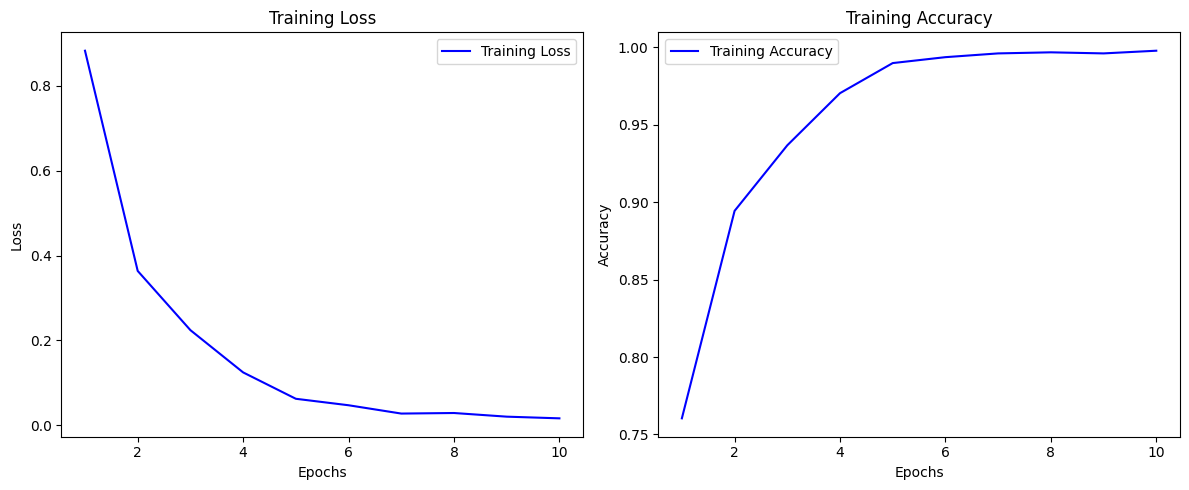

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from PIL import Image
import requests
from io import BytesIO
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Load datasets
train_dataset_path = '/content/drive/MyDrive/Labelling/balanced_train_dataset.csv'
test_dataset_path = '/content/drive/MyDrive/Labelling/balanced_test_dataset.csv'

train_df = pd.read_csv(train_dataset_path)
test_df = pd.read_csv(test_dataset_path)

# Label encoding for sub_categories
label_encoder = LabelEncoder()
train_df['sub_category'] = label_encoder.fit_transform(train_df['sub_category'])
test_df['sub_category'] = label_encoder.transform(test_df['sub_category'])

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_url = self.data.iloc[idx]['image']
        label = self.data.iloc[idx]['sub_category']

        response = requests.get(image_url)
        image = Image.open(BytesIO(response.content)).convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image, label

# Example transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create datasets and DataLoaders with a limit of 90 batches
train_dataset = CustomDataset(train_df, transform=transform)
test_dataset = CustomDataset(test_df, transform=transform)

# Subset to limit batches to 90 (32*90=2880 samples)
train_subset_indices = np.random.choice(len(train_dataset), 2880, replace=False)
train_loader = DataLoader(Subset(train_dataset, train_subset_indices), batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Define CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.fc1(x))
        return x

# Define hybrid model using vit_b_16 only
class HybridModel(nn.Module):
    def __init__(self, num_classes):
        super(HybridModel, self).__init__()
        self.cnn = SimpleCNN()

        # Load vit_b_16 with weights
        self.vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)

        # Freeze ViT parameters to save memory, adjust if fine-tuning is needed
        for param in self.vit.parameters():
            param.requires_grad = False

        vit_dim = 1000  # Dimension of ViT model output
        self.classifier = nn.Linear(128 + vit_dim, num_classes)

    def forward(self, x):
        cnn_out = self.cnn(x)

        # Pass through ViT model and get the output tensor directly
        vit_out = self.vit(x)  # Directly take the output tensor

        # Concatenate outputs and pass to the classifier
        combined = torch.cat((cnn_out, vit_out), dim=1)
        return self.classifier(combined)

# Initialize model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridModel(num_classes=len(label_encoder.classes_)).to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Directory for saving best model
model_dir = '/content/drive/MyDrive/Labelling/saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Training function with 90 batches per epoch
def train_model(model, train_loader, optimizer, criterion, num_epochs=10):
    best_val_loss = float('inf')
    train_loss_history = []
    train_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total_batches = 90

        for i, (images, labels) in enumerate(train_loader):
            if i >= total_batches:
                break
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            if i % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_batches}], Loss: {loss.item():.4f}')

        train_loss = running_loss / total_batches
        train_acc = correct / (total_batches * 32)
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] Training Loss: {train_loss:.4f}, Training Acc: {train_acc:.4f}')

        # Save best model based on training loss
        if train_loss < best_val_loss:
            best_val_loss = train_loss
            torch.save(model.state_dict(), os.path.join(model_dir, f'best_model_epoch_{epoch+1}.pth'))
            print(f'Model saved to {model_dir}/best_model_epoch_{epoch+1}.pth')

    return train_loss_history, train_acc_history

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_acc = correct / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    return test_loss, test_acc

# Plotting function
def plot_metrics(train_loss, train_acc):
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Train and evaluate the model
train_loss_history, train_acc_history = train_model(model, train_loader, optimizer, criterion, num_epochs=10)
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
plot_metrics(train_loss_history, train_acc_history)

In [2]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 18.7 MB/s eta 0:00:00


In [9]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import cv2
import easyocr
import random

# Custom Hybrid Model Definition
class CustomHybridModel(nn.Module):
    def __init__(self, num_classes=11):
        super(CustomHybridModel, self).__init__()
        # CNN Branch
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # ViT Branch
        self.vit = torch.hub.load('pytorch/vision:v0.13.0', 'vit_b_16', weights="IMAGENET1K_V1")
        self.vit.heads = nn.Identity()  # Removing classification head

        # Fully Connected Layers for Hybrid Model
        self.fc1 = nn.Linear(32 * 56 * 56 + 768, 256)  # Adjusted size after ViT & CNN branches
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # CNN Branch
        cnn_out = self.pool(torch.relu(self.conv1(x)))
        cnn_out = self.pool(torch.relu(self.conv2(cnn_out)))
        cnn_out = cnn_out.view(-1, 32 * 56 * 56)

        # ViT Branch
        vit_out = self.vit(x)
        if vit_out.dim() == 2:  # If output is 2D, it includes the [CLS] token
            vit_out = vit_out[:, :768]  # Adjusting to ensure correct shape (batch size, hidden size)

        # Combine CNN and ViT features
        combined = torch.cat((cnn_out, vit_out), dim=1)

        # Fully Connected Layers
        x = torch.relu(self.fc1(combined))
        x = self.fc2(x)
        return x

# Load Model
def load_model(model_path, num_classes=11):
    model = CustomHybridModel(num_classes)
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    return model

# Label Mapping
label_mapping = {
    0: "Backpack",
    1: "Badminton Racquet",
    2: "Kids' Watch",
    3: "Refrigerator",
    4: "Shirt",
    5: "Speaker",
    6: "Suitcase",
    7: "Sunglasses",
    8: "Television",
    9: "Washing Machine",
    10: "Men's Sports Shoe"
}

# Color Extraction
def extract_colors(image, n_colors=3):
    img_np = np.array(image)
    img_reshaped = img_np.reshape((-1, 3))
    kmeans = KMeans(n_clusters=n_colors).fit(img_reshaped)
    colors = kmeans.cluster_centers_.astype(int)

    color_names = []
    for color in colors:
        r, g, b = color
        if r > 200 and g > 200 and b > 200:
            color_names.append("white")
        elif r > 200 and g < 100 and b < 100:
            color_names.append("red")
        elif r < 100 and g > 200 and b < 100:
            color_names.append("green")
        elif r < 100 and g < 100 and b > 200:
            color_names.append("blue")
        elif r > 200 and g > 200 and b < 100:
            color_names.append("yellow")
        elif r > 150 and g > 100 and b < 100:
            color_names.append("orange")
        elif r < 50 and g < 50 and b < 50:
            color_names.append("black")
        else:
            color_names.append("gray")

    return list(set(color_names))

# Shape Detection
def detect_shapes(image):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 30, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shapes = []
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.04 * cv2.arcLength(cnt, True), True)
        if len(approx) == 3:
            shapes.append("triangular")
        elif len(approx) == 4:
            shapes.append("rectangular")
        elif len(approx) > 10:
            shapes.append("circular")
        else:
            shapes.append("irregular")

    return list(set(shapes))

# Brand Extraction
def extract_brand(image):
    reader = easyocr.Reader(['en'])
    ocr_results = reader.readtext(np.array(image), detail=0)

    if ocr_results:
        filtered_texts = [text for text in ocr_results if text.isalnum() and len(text) > 2]
        if filtered_texts:
            brand = max(set(filtered_texts), key=filtered_texts.count)
            return brand.capitalize()
    return "Unbranded"

# Description Generation
def generate_description(label, colors, shapes, brand):
    color_desc = ', '.join(colors)
    shape_desc = ', '.join(shapes)
    accessory = ""

    if "Backpack" in label:
        accessory = "with multiple compartments and durable straps"
    elif "Suitcase" in label:
        accessory = "featuring a telescopic handle and secure locks"
    elif "Watch" in label:
        accessory = "with a sleek wrist strap and water resistance"
    elif "Shirt" in label:
        accessory = "made from comfortable, breathable fabric"

    description_templates = [
        f"This is a {label.lower()} with a {color_desc} color scheme and a {shape_desc} design, {accessory}.",
        f"A stylish {label.lower()} in shades of {color_desc}, {shape_desc} in structure, {accessory}.",
        f"This {label.lower()} stands out with its {color_desc} tones and {shape_desc} shape, ideal for practical use. Brand: {brand}.",
        f"An eye-catching {label.lower()} with {color_desc} colors, a {shape_desc} style, and {accessory}."
    ]

    if brand != "Unbranded":
        description_templates.append(f"A {label.lower()} by {brand}, showcasing {color_desc} hues, a {shape_desc} shape, and {accessory}.")

    return random.choice(description_templates)

# Main Analysis Pipeline
def analyze_image(image_path, model, label_mapping):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    img_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)
        label = label_mapping[predicted.item()]

    colors = extract_colors(image)
    shapes = detect_shapes(image)
    brand = extract_brand(image)
    description = generate_description(label, colors, shapes, brand)

    print(f"Label: {label}")
    print(f"Colors: {colors}")
    print(f"Shapes: {shapes}")
    print(f"Brand: {brand}")
    print(f"Description: {description}")

# Run Analysis
model_path = '/content/drive/MyDrive/Labelling/saved_models/best_model_epoch_10.pth'
model = load_model(model_path)

# Analyze Image
analyze_image('/content/123.webp', model, label_mapping)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0
<ipython-input-9-5f5bfd5780f2>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(m

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteLabel: Television
Colors: ['white', 'gray']
Shapes: ['rectangular', 'triangular', 'irregular']
Brand: Unbranded
Description: An eye-catching television with white, gray colors, a rectangular, triangular, irregular style, and .


In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from PIL import Image
import requests
from io import BytesIO
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Load datasets
train_dataset_path = '/content/drive/MyDrive/Labelling/balanced_train_dataset.csv'
test_dataset_path = '/content/drive/MyDrive/Labelling/balanced_test_dataset.csv'

train_df = pd.read_csv(train_dataset_path)
test_df = pd.read_csv(test_dataset_path)

# Label encoding for sub_categories
label_encoder = LabelEncoder()
train_df['sub_category'] = label_encoder.fit_transform(train_df['sub_category'])
test_df['sub_category'] = label_encoder.transform(test_df['sub_category'])

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_url = self.data.iloc[idx]['image']
        label = self.data.iloc[idx]['sub_category']

        response = requests.get(image_url)
        image = Image.open(BytesIO(response.content)).convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image, label

# Example transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create datasets and DataLoaders with a limit of 90 batches
train_dataset = CustomDataset(train_df, transform=transform)
test_dataset = CustomDataset(test_df, transform=transform)

# Split train dataset into train and validation subsets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Define CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.fc1(x))
        return x

# Define hybrid model using vit_b_16 only
class HybridModel(nn.Module):
    def __init__(self, num_classes):
        super(HybridModel, self).__init__()
        self.cnn = SimpleCNN()
        self.vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)

        # Freeze ViT parameters to save memory, adjust if fine-tuning is needed
        for param in self.vit.parameters():
            param.requires_grad = False

        vit_dim = 1000  # Dimension of ViT model output
        self.classifier = nn.Linear(128 + vit_dim, num_classes)

    def forward(self, x):
        cnn_out = self.cnn(x)
        vit_out = self.vit(x)
        combined = torch.cat((cnn_out, vit_out), dim=1)
        return self.classifier(combined)

# Initialize model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridModel(num_classes=len(label_encoder.classes_)).to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

model_dir = '/content/drive/MyDrive/Labelling/saved_models_2'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Training function with validation step
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=10):
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train = 0.0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels)

        train_loss /= len(train_loader.dataset)
        train_acc = correct_train.double() / len(train_loader.dataset)

        # Validation step
        model.eval()
        val_loss, correct_val = 0.0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val += torch.sum(preds == labels)

        val_loss /= len(val_loader.dataset)
        val_acc = correct_val.double() / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(model_dir, f'best_model_epoch_{epoch+1}.pth'))
            print(f"Model saved with Validation Loss: {val_loss:.4f}")

    return model

# Train and evaluate the model
model = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=10)

# Evaluation function for test data
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss, correct = 0.0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)

    test_loss /= len(test_loader.dataset)
    test_acc = correct.double() / len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    return test_loss, test_acc

# Evaluate on test set
test_loss, test_acc = evaluate_model(model, test_loader, criterion)

Epoch 1/10, Train Loss: 0.6403, Train Acc: 0.8151, Val Loss: 0.3840, Val Acc: 0.8920
Model saved with Validation Loss: 0.3840
Epoch 2/10, Train Loss: 0.2999, Train Acc: 0.9115, Val Loss: 0.3013, Val Acc: 0.9115
Model saved with Validation Loss: 0.3013
Epoch 3/10, Train Loss: 0.1809, Train Acc: 0.9467, Val Loss: 0.3219, Val Acc: 0.9038
Epoch 4/10, Train Loss: 0.0909, Train Acc: 0.9780, Val Loss: 0.3388, Val Acc: 0.8976
Epoch 5/10, Train Loss: 0.0407, Train Acc: 0.9918, Val Loss: 0.3254, Val Acc: 0.9045
Epoch 6/10, Train Loss: 0.0258, Train Acc: 0.9956, Val Loss: 0.3469, Val Acc: 0.9073
Epoch 7/10, Train Loss: 0.0230, Train Acc: 0.9962, Val Loss: 0.3657, Val Acc: 0.9052
Epoch 8/10, Train Loss: 0.0156, Train Acc: 0.9979, Val Loss: 0.3812, Val Acc: 0.8976
Epoch 9/10, Train Loss: 0.0135, Train Acc: 0.9974, Val Loss: 0.5210, Val Acc: 0.8746
Epoch 10/10, Train Loss: 0.0157, Train Acc: 0.9974, Val Loss: 0.4837, Val Acc: 0.8948
Test Loss: 0.4503, Test Acc: 0.8930


In [20]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import cv2
import easyocr
import random

# Custom Hybrid Model Definition
class CustomHybridModel(nn.Module):
    def __init__(self, num_classes=11):
        super(CustomHybridModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.vit = torch.hub.load('pytorch/vision:v0.13.0', 'vit_b_16', weights="IMAGENET1K_V1")
        self.vit.heads = nn.Identity()  # Removing classification head

        # Adjusted for compatibility
        self.fc1 = nn.Linear(32 * 56 * 56 + 768, 128)  # Changed to match saved model
        self.fc2 = nn.Linear(128, num_classes)  # Changed to match saved model

    def forward(self, x):
        cnn_out = self.pool(torch.relu(self.conv1(x)))
        cnn_out = self.pool(torch.relu(self.conv2(cnn_out)))
        cnn_out = cnn_out.view(-1, 32 * 56 * 56)

        vit_out = self.vit(x)
        if vit_out.dim() == 2:
            vit_out = vit_out[:, :768]

        combined = torch.cat((cnn_out, vit_out), dim=1)
        x = torch.relu(self.fc1(combined))
        x = self.fc2(x)
        return x

# Load Model
def load_model(model_path, num_classes=11):
    model = CustomHybridModel(num_classes)
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    return model

# Label Mapping
label_mapping = {
    0: "Backpack",
    1: "Badminton Racquet",
    2: "Kids' Watch",
    3: "Refrigerator",
    4: "Shirt",
    5: "Speaker",
    6: "Suitcase",
    7: "Sunglasses",
    8: "Television",
    9: "Washing Machine",
    10: "Men's Sports Shoe"
}

# Color Extraction
def extract_colors(image, n_colors=3):
    img_np = np.array(image)
    img_reshaped = img_np.reshape((-1, 3))
    kmeans = KMeans(n_clusters=n_colors).fit(img_reshaped)
    colors = kmeans.cluster_centers_.astype(int)

    color_names = []
    for color in colors:
        r, g, b = color
        if r > 200 and g > 200 and b > 200:
            color_names.append("white")
        elif r > 200 and g < 100 and b < 100:
            color_names.append("red")
        elif r < 100 and g > 200 and b < 100:
            color_names.append("green")
        elif r < 100 and g < 100 and b > 200:
            color_names.append("blue")
        elif r > 200 and g > 200 and b < 100:
            color_names.append("yellow")
        elif r > 150 and g > 100 and b < 100:
            color_names.append("orange")
        elif r < 50 and g < 50 and b < 50:
            color_names.append("black")
        else:
            color_names.append("gray")

    return list(set(color_names))

# Shape Detection
def detect_shapes(image):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 30, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shapes = []
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.04 * cv2.arcLength(cnt, True), True)
        if len(approx) == 3:
            shapes.append("triangular")
        elif len(approx) == 4:
            shapes.append("rectangular")
        elif len(approx) > 10:
            shapes.append("circular")
        else:
            shapes.append("irregular")

    return list(set(shapes))

# Brand Extraction
def extract_brand(image):
    reader = easyocr.Reader(['en'])
    ocr_results = reader.readtext(np.array(image), detail=0)

    if ocr_results:
        filtered_texts = [text for text in ocr_results if text.isalnum() and len(text) > 2]
        if filtered_texts:
            brand = max(set(filtered_texts), key=filtered_texts.count)
            return brand.capitalize()
    return "Unbranded"

# Description Generation
def generate_description(label, colors, shapes, brand):
    color_desc = ', '.join(colors)
    shape_desc = ', '.join(shapes)
    accessory = ""

    if "Backpack" in label:
        accessory = "with multiple compartments and durable straps"
    elif "Suitcase" in label:
        accessory = "featuring a telescopic handle and secure locks"
    elif "Watch" in label:
        accessory = "with a sleek wrist strap and water resistance"
    elif "Shirt" in label:
        accessory = "made from comfortable, breathable fabric"

    description_templates = [
        f"This is a {label.lower()} with a {color_desc} color scheme and a {shape_desc} design, {accessory}.",
        f"A stylish {label.lower()} in shades of {color_desc}, {shape_desc} in structure, {accessory}.",
        f"This {label.lower()} stands out with its {color_desc} tones and {shape_desc} shape, ideal for practical use. Brand: {brand}.",
        f"An eye-catching {label.lower()} with {color_desc} colors, a {shape_desc} style, and {accessory}."
    ]

    if brand != "Unbranded":
        description_templates.append(f"A {label.lower()} by {brand}, showcasing {color_desc} hues, a {shape_desc} shape, and {accessory}.")

    return random.choice(description_templates)

# Main Analysis Pipeline
def analyze_image(image_path, model, label_mapping):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    img_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)
        label = label_mapping[predicted.item()]

    colors = extract_colors(image)
    shapes = detect_shapes(image)
    brand = extract_brand(image)
    description = generate_description(label, colors, shapes, brand)

    print(f"Label: {label}")
    print(f"Colors: {colors}")
    print(f"Shapes: {shapes}")
    print(f"Brand: {brand}")
    print(f"Description: {description}")

# Run Analysis
model_path = '/content/drive/MyDrive/Labelling/saved_models_2/best_model_epoch_1.pth'
model = load_model(model_path)

# Analyze Image
analyze_image('/content/555.jpg', model, label_mapping)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0
<ipython-input-20-46506716ae73>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(

Label: Backpack
Colors: ['black', 'white', 'gray']
Shapes: ['rectangular', 'triangular', 'irregular']
Brand: Unbranded
Description: This is a backpack with a black, white, gray color scheme and a rectangular, triangular, irregular design, with multiple compartments and durable straps.


In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import cv2
import easyocr
import random

# Custom Hybrid Model Definition
class CustomHybridModel(nn.Module):
    def __init__(self, num_classes=11):
        super(CustomHybridModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.vit = torch.hub.load('pytorch/vision:v0.13.0', 'vit_b_16', weights="IMAGENET1K_V1")
        self.vit.heads = nn.Identity()  # Removing classification head

        # Adjusted for compatibility
        self.fc1 = nn.Linear(32 * 56 * 56 + 768, 128)  # Changed to match saved model
        self.fc2 = nn.Linear(128, num_classes)  # Changed to match saved model

    def forward(self, x):
        cnn_out = self.pool(torch.relu(self.conv1(x)))
        cnn_out = self.pool(torch.relu(self.conv2(cnn_out)))
        cnn_out = cnn_out.view(-1, 32 * 56 * 56)

        vit_out = self.vit(x)
        if vit_out.dim() == 2:
            vit_out = vit_out[:, :768]

        combined = torch.cat((cnn_out, vit_out), dim=1)
        x = torch.relu(self.fc1(combined))
        x = self.fc2(x)
        return x

# Load Model
def load_model(model_path, num_classes=11):
    model = CustomHybridModel(num_classes)
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    return model

# Label Mapping
label_mapping = {
    0: "Backpack",
    1: "Badminton Racquet",
    2: "Kids' Watch",
    3: "Refrigerator",
    4: "Shirt",
    5: "Speaker",
    6: "Suitcase",
    7: "Sunglasses",
    8: "Television",
    9: "Washing Machine",
    10: "Men's Sports Shoe"
}

# Color Extraction
def extract_colors(image, n_colors=3):
    img_np = np.array(image)
    img_reshaped = img_np.reshape((-1, 3))
    kmeans = KMeans(n_clusters=n_colors).fit(img_reshaped)
    colors = kmeans.cluster_centers_.astype(int)

    color_names = []
    for color in colors:
        r, g, b = color
        if r > 200 and g > 200 and b > 200:
            color_names.append("white")
        elif r > 200 and g < 100 and b < 100:
            color_names.append("red")
        elif r < 100 and g > 200 and b < 100:
            color_names.append("green")
        elif r < 100 and g < 100 and b > 200:
            color_names.append("blue")
        elif r > 200 and g > 200 and b < 100:
            color_names.append("yellow")
        elif r > 150 and g > 100 and b < 100:
            color_names.append("orange")
        elif r < 50 and g < 50 and b < 50:
            color_names.append("black")
        else:
            color_names.append("gray")

    return list(set(color_names))

# Shape Detection
def detect_shapes(image):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 30, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shapes = []
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.04 * cv2.arcLength(cnt, True), True)
        if len(approx) == 3:
            shapes.append("triangular")
        elif len(approx) == 4:
            shapes.append("rectangular")
        elif len(approx) > 10:
            shapes.append("circular")
        else:
            shapes.append("irregular")

    return list(set(shapes))

# Brand Extraction
def extract_brand(image):
    reader = easyocr.Reader(['en'])
    ocr_results = reader.readtext(np.array(image), detail=0)

    if ocr_results:
        filtered_texts = [text for text in ocr_results if text.isalnum() and len(text) > 2]
        if filtered_texts:
            brand = max(set(filtered_texts), key=filtered_texts.count)
            return brand.capitalize()
    return "Unbranded"

# Description Generation
def generate_description(label, colors, shapes, brand):
    color_desc = ', '.join(colors)
    shape_desc = ', '.join(shapes)
    accessory = ""

    if "Backpack" in label:
        accessory = "with multiple compartments and durable straps"
    elif "Suitcase" in label:
        accessory = "featuring a telescopic handle and secure locks"
    elif "Watch" in label:
        accessory = "with a sleek wrist strap and water resistance"
    elif "Shirt" in label:
        accessory = "made from comfortable, breathable fabric"

    description_templates = [
        f"This is a {label.lower()} with a {color_desc} color scheme and a {shape_desc} design, {accessory}.",
        f"A stylish {label.lower()} in shades of {color_desc}, {shape_desc} in structure, {accessory}.",
        f"This {label.lower()} stands out with its {color_desc} tones and {shape_desc} shape, ideal for practical use. Brand: {brand}.",
        f"An eye-catching {label.lower()} with {color_desc} colors, a {shape_desc} style, and {accessory}."
    ]

    if brand != "Unbranded":
        description_templates.append(f"A {label.lower()} by {brand}, showcasing {color_desc} hues, a {shape_desc} shape, and {accessory}.")

    return random.choice(description_templates)

# Main Analysis Pipeline
def analyze_image(image_path, model, label_mapping):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    img_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)
        label = label_mapping[predicted.item()]

    colors = extract_colors(image)
    shapes = detect_shapes(image)
    brand = extract_brand(image)
    description = generate_description(label, colors, shapes, brand)

    print(f"Label: {label}")
    print(f"Colors: {colors}")
    print(f"Shapes: {shapes}")
    print(f"Brand: {brand}")
    print(f"Description: {description}")

# Run Analysis
model_path = '/content/drive/MyDrive/Labelling/saved_models_2/best_model_epoch_2.pth'
model = load_model(model_path)

# Analyze Image
analyze_image('/content/shirt.jpg', model, label_mapping)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0
<ipython-input-4-203cddf90c3b>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(m

Label: Refrigerator
Colors: ['white', 'gray']
Shapes: ['triangular', 'irregular', 'rectangular']
Brand: Unbranded
Description: A stylish refrigerator in shades of white, gray, triangular, irregular, rectangular in structure, .


In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import cv2
import easyocr
import random

# Custom Hybrid Model Definition
class CustomHybridModel(nn.Module):
    def __init__(self, num_classes=11):
        super(CustomHybridModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.vit = torch.hub.load('pytorch/vision:v0.13.0', 'vit_b_16', weights="IMAGENET1K_V1")
        self.vit.heads = nn.Identity()  # Removing classification head

        # Adjusted for compatibility
        self.fc1 = nn.Linear(32 * 56 * 56 + 768, 128)  # Changed to match saved model
        self.fc2 = nn.Linear(128, num_classes)  # Changed to match saved model

    def forward(self, x):
        cnn_out = self.pool(torch.relu(self.conv1(x)))
        cnn_out = self.pool(torch.relu(self.conv2(cnn_out)))
        cnn_out = cnn_out.view(-1, 32 * 56 * 56)

        vit_out = self.vit(x)
        if vit_out.dim() == 2:
            vit_out = vit_out[:, :768]

        combined = torch.cat((cnn_out, vit_out), dim=1)
        x = torch.relu(self.fc1(combined))
        x = self.fc2(x)
        return x

# Load Model
def load_model(model_path, num_classes=11):
    model = CustomHybridModel(num_classes)
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    return model

# Label Mapping
label_mapping = {
    0: "Backpack",
    1: "Badminton Racquet",
    2: "Kids' Watch",
    3: "Refrigerator",
    4: "Shirt",
    5: "Speaker",
    6: "Suitcase",
    7: "Sunglasses",
    8: "Television",
    9: "Washing Machine",
    10: "Men's Sports Shoe"
}

# Color Extraction
def extract_colors(image, n_colors=3):
    img_np = np.array(image)
    img_reshaped = img_np.reshape((-1, 3))
    kmeans = KMeans(n_clusters=n_colors).fit(img_reshaped)
    colors = kmeans.cluster_centers_.astype(int)

    color_names = []
    for color in colors:
        r, g, b = color
        if r > 200 and g > 200 and b > 200:
            color_names.append("white")
        elif r > 200 and g < 100 and b < 100:
            color_names.append("red")
        elif r < 100 and g > 200 and b < 100:
            color_names.append("green")
        elif r < 100 and g < 100 and b > 200:
            color_names.append("blue")
        elif r > 200 and g > 200 and b < 100:
            color_names.append("yellow")
        elif r > 150 and g > 100 and b < 100:
            color_names.append("orange")
        elif r < 50 and g < 50 and b < 50:
            color_names.append("black")
        else:
            color_names.append("gray")

    return list(set(color_names))

# Shape Detection
def detect_shapes(image):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 30, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shapes = []
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.04 * cv2.arcLength(cnt, True), True)
        if len(approx) == 3:
            shapes.append("triangular")
        elif len(approx) == 4:
            shapes.append("rectangular")
        elif len(approx) > 10:
            shapes.append("circular")
        else:
            shapes.append("irregular")

    return list(set(shapes))

# Brand Extraction
def extract_brand(image):
    reader = easyocr.Reader(['en'])
    ocr_results = reader.readtext(np.array(image), detail=0)

    if ocr_results:
        filtered_texts = [text for text in ocr_results if text.isalnum() and len(text) > 2]
        if filtered_texts:
            brand = max(set(filtered_texts), key=filtered_texts.count)
            return brand.capitalize()
    return "Unbranded"

# Description Generation
def generate_description(label, colors, shapes, brand):
    color_desc = ', '.join(colors)
    shape_desc = ', '.join(shapes)
    accessory = ""

    if "Backpack" in label:
        accessory = "with multiple compartments and durable straps"
    elif "Suitcase" in label:
        accessory = "featuring a telescopic handle and secure locks"
    elif "Watch" in label:
        accessory = "with a sleek wrist strap and water resistance"
    elif "Shirt" in label:
        accessory = "made from comfortable, breathable fabric"

    description_templates = [
        f"This is a {label.lower()} with a {color_desc} color scheme and a {shape_desc} design, {accessory}.",
        f"A stylish {label.lower()} in shades of {color_desc}, {shape_desc} in structure, {accessory}.",
        f"This {label.lower()} stands out with its {color_desc} tones and {shape_desc} shape, ideal for practical use. Brand: {brand}.",
        f"An eye-catching {label.lower()} with {color_desc} colors, a {shape_desc} style, and {accessory}."
    ]

    if brand != "Unbranded":
        description_templates.append(f"A {label.lower()} by {brand}, showcasing {color_desc} hues, a {shape_desc} shape, and {accessory}.")

    return random.choice(description_templates)

# Main Analysis Pipeline
def analyze_image(image_path, model, label_mapping):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    img_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)
        label = label_mapping[predicted.item()]

    colors = extract_colors(image)
    shapes = detect_shapes(image)
    brand = extract_brand(image)
    description = generate_description(label, colors, shapes, brand)

    print(f"Label: {label}")
    print(f"Colors: {colors}")
    print(f"Shapes: {shapes}")
    print(f"Brand: {brand}")
    print(f"Description: {description}")

# Run Analysis
model_path = '/content/drive/MyDrive/Labelling/saved_models_2/best_model_epoch_2.pth'
model = load_model(model_path)

# Analyze Image
analyze_image('/content/shirt.jpg', model, label_mapping)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0
<ipython-input-4-203cddf90c3b>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(m

Label: Kids' Watch
Colors: ['gray', 'white']
Shapes: ['triangular', 'rectangular', 'irregular']
Brand: Nike
Description: A stylish kids' watch in shades of gray, white, triangular, rectangular, irregular in structure, with a sleek wrist strap and water resistance.


In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import cv2
import easyocr
import random

# Custom Hybrid Model Definition
class CustomHybridModel(nn.Module):
    def __init__(self, num_classes=11):
        super(CustomHybridModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.vit = torch.hub.load('pytorch/vision:v0.13.0', 'vit_b_16', weights="IMAGENET1K_V1")
        self.vit.heads = nn.Identity()  # Removing classification head

        # Adjusted for compatibility
        self.fc1 = nn.Linear(32 * 56 * 56 + 768, 128)  # Changed to match saved model
        self.fc2 = nn.Linear(128, num_classes)  # Changed to match saved model

    def forward(self, x):
        cnn_out = self.pool(torch.relu(self.conv1(x)))
        cnn_out = self.pool(torch.relu(self.conv2(cnn_out)))
        cnn_out = cnn_out.view(-1, 32 * 56 * 56)

        vit_out = self.vit(x)
        if vit_out.dim() == 2:
            vit_out = vit_out[:, :768]

        combined = torch.cat((cnn_out, vit_out), dim=1)
        x = torch.relu(self.fc1(combined))
        x = self.fc2(x)
        return x

# Load Model
def load_model(model_path, num_classes=11):
    model = CustomHybridModel(num_classes)
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    return model

# Label Mapping
label_mapping = {
    0: "Backpack",
    1: "Badminton Racquet",
    2: "Kids' Watch",
    3: "Refrigerator",
    4: "Shirt",
    5: "Speaker",
    6: "Suitcase",
    7: "Sunglasses",
    8: "Television",
    9: "Washing Machine",
    10: "Men's Sports Shoe"
}

# Color Extraction
def extract_colors(image, n_colors=3):
    img_np = np.array(image)
    img_reshaped = img_np.reshape((-1, 3))
    kmeans = KMeans(n_clusters=n_colors).fit(img_reshaped)
    colors = kmeans.cluster_centers_.astype(int)

    color_names = []
    for color in colors:
        r, g, b = color
        if r > 200 and g > 200 and b > 200:
            color_names.append("white")
        elif r > 200 and g < 100 and b < 100:
            color_names.append("red")
        elif r < 100 and g > 200 and b < 100:
            color_names.append("green")
        elif r < 100 and g < 100 and b > 200:
            color_names.append("blue")
        elif r > 200 and g > 200 and b < 100:
            color_names.append("yellow")
        elif r > 150 and g > 100 and b < 100:
            color_names.append("orange")
        elif r < 50 and g < 50 and b < 50:
            color_names.append("black")
        else:
            color_names.append("gray")

    return list(set(color_names))

# Shape Detection
def detect_shapes(image):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 30, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shapes = []
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.04 * cv2.arcLength(cnt, True), True)
        if len(approx) == 3:
            shapes.append("triangular")
        elif len(approx) == 4:
            shapes.append("rectangular")
        elif len(approx) > 10:
            shapes.append("circular")
        else:
            shapes.append("irregular")

    return list(set(shapes))

# Brand Extraction
def extract_brand(image):
    reader = easyocr.Reader(['en'])
    ocr_results = reader.readtext(np.array(image), detail=0)

    if ocr_results:
        filtered_texts = [text for text in ocr_results if text.isalnum() and len(text) > 2]
        if filtered_texts:
            brand = max(set(filtered_texts), key=filtered_texts.count)
            return brand.capitalize()
    return "Unbranded"

# Description Generation
def generate_description(label, colors, shapes, brand):
    color_desc = ', '.join(colors)
    shape_desc = ', '.join(shapes)
    accessory = ""

    if "Backpack" in label:
        accessory = "with multiple compartments and durable straps"
    elif "Suitcase" in label:
        accessory = "featuring a telescopic handle and secure locks"
    elif "Watch" in label:
        accessory = "with a sleek wrist strap and water resistance"
    elif "Shirt" in label:
        accessory = "made from comfortable, breathable fabric"

    description_templates = [
        f"This is a {label.lower()} with a {color_desc} color scheme and a {shape_desc} design, {accessory}.",
        f"A stylish {label.lower()} in shades of {color_desc}, {shape_desc} in structure, {accessory}.",
        f"This {label.lower()} stands out with its {color_desc} tones and {shape_desc} shape, ideal for practical use. Brand: {brand}.",
        f"An eye-catching {label.lower()} with {color_desc} colors, a {shape_desc} style, and {accessory}."
    ]

    if brand != "Unbranded":
        description_templates.append(f"A {label.lower()} by {brand}, showcasing {color_desc} hues, a {shape_desc} shape, and {accessory}.")

    return random.choice(description_templates)

# Main Analysis Pipeline
def analyze_image(image_path, model, label_mapping):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    img_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)
        label = label_mapping[predicted.item()]

    colors = extract_colors(image)
    shapes = detect_shapes(image)
    brand = extract_brand(image)
    description = generate_description(label, colors, shapes, brand)

    print(f"Label: {label}")
    print(f"Colors: {colors}")
    print(f"Shapes: {shapes}")
    print(f"Brand: {brand}")
    print(f"Description: {description}")

# Run Analysis
model_path = '/content/drive/MyDrive/Labelling/saved_models_2/best_model_epoch_2.pth'
model = load_model(model_path)

# Analyze Image
analyze_image('/content/fgg.jpg', model, label_mapping)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0
<ipython-input-5-ab9caabd34a2>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(m

Label: Men's Sports Shoe
Colors: ['gray', 'white']
Shapes: ['irregular']
Brand: Unbranded
Description: This men's sports shoe stands out with its gray, white tones and irregular shape, ideal for practical use. Brand: Unbranded.
